Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [10]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import load_img


In [11]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [12]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("gdrive/My Drive/Colab Notebooks/Train")
data_dir_test = pathlib.Path('gdrive/My Drive/Colab Notebooks/Test')

In [13]:
# count of Train and Test data set impages
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [14]:
   = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [15]:
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(img_height,img_width), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [16]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(img_height,img_width), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [17]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
for i in class_names:
  print(i)

actinic keratosis
basal cell carcinoma
dermatofibroma
melanoma
nevus
pigmented benign keratosis
seborrheic keratosis
squamous cell carcinoma
vascular lesion


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

Found 2239 files belonging to 9 classes.


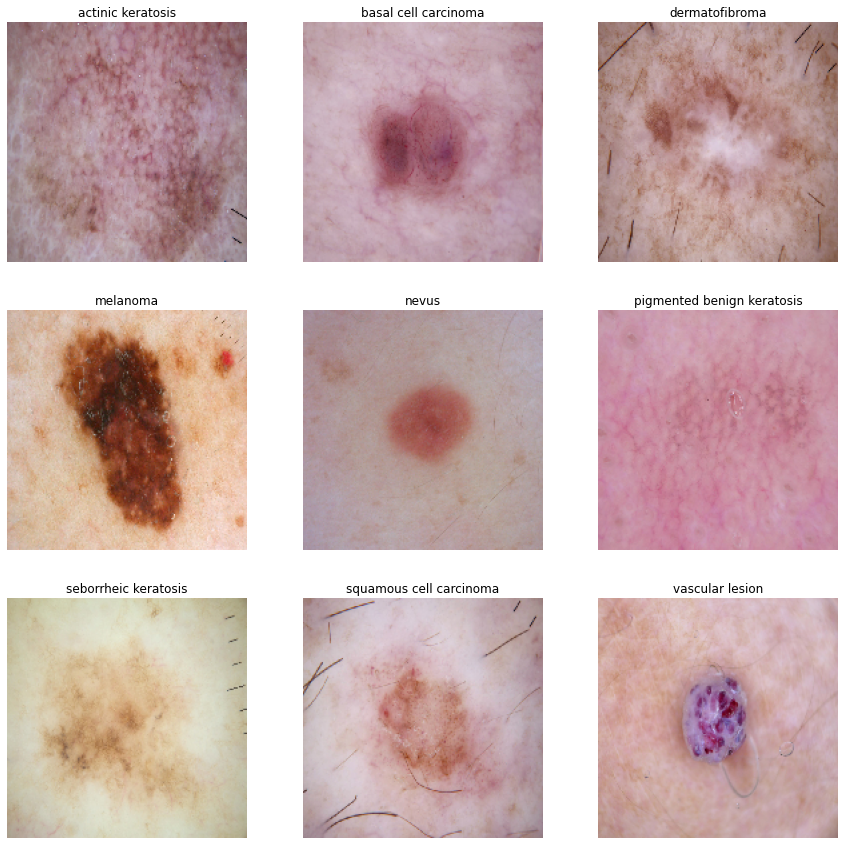

In [18]:
import matplotlib.pyplot as plt

#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [19]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [20]:
#Compile the Model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [21]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Train the model

In [22]:
# Train the model
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/20
55/56 [============================>.] - ETA: 9s - loss: 2.0741 - accuracy: 0.2250 
Epoch 1: val_accuracy improved from -inf to 0.35794, saving model to model.h5
56/56 [==============================] - 766s 12s/step - loss: 2.0738 - accuracy: 0.2249 - val_loss: 1.8409 - val_accuracy: 0.3579
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 1.7533 - accuracy: 0.3521
Epoch 2: val_accuracy improved from 0.35794 to 0.46532, saving model to model.h5
56/56 [==============================] - 16s 248ms/step - loss: 1.7533 - accuracy: 0.3521 - val_loss: 1.6185 - val_accuracy: 0.4653
Epoch 3/20
56/56 [==============================] - ETA: 0s - loss: 1.5893 - accuracy: 0.4498
Epoch 3: val_accuracy improved from 0.46532 to 0.50112, saving model to model.h5
56/56 [==============================] - 16s 247ms/step - loss: 1.5893 - accuracy: 0.4498 - val_loss: 1.4854 - val_accuracy: 0.5011
Epoch 4/20
56/56 [==============================] - ETA: 0s - loss: 1.4550 - accur

### Visualizing training results

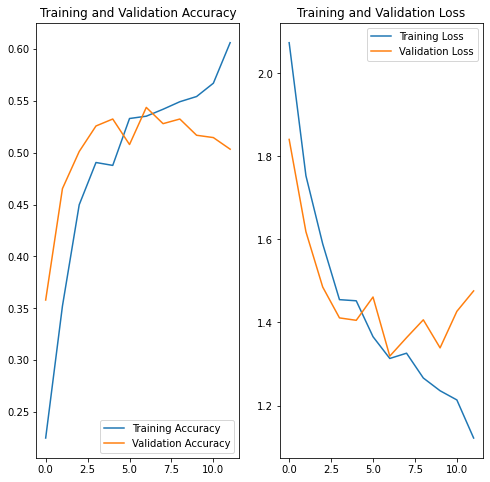

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs_range = range(epochs)
epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


#### Here we can see our Validation loss is decresing that means our model is underfit. So we are augmentate images and will re-train the model and check the o/p

In [32]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
]
)

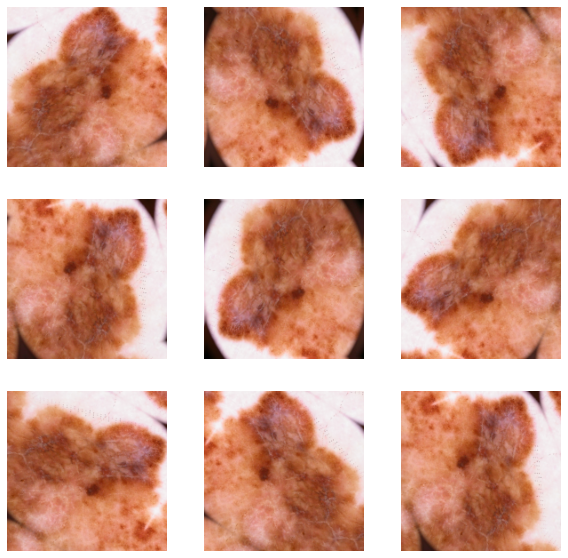

In [33]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):   
    for i in range(9):
        augmented_images = data_augmentation(images,training = True)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[1].numpy().astype("uint8"))
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [34]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 41, 41, 128)      

### Compiling the model

In [35]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

### Training the model

In [42]:
# Train the model
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/20
55/56 [============================>.] - ETA: 0s - loss: 0.1949 - accuracy: 0.9091
Epoch 1: val_accuracy did not improve from 0.55257
56/56 [==============================] - 15s 241ms/step - loss: 0.1925 - accuracy: 0.9107 - val_loss: 3.0796 - val_accuracy: 0.5280
Epoch 2/20
55/56 [============================>.] - ETA: 0s - loss: 0.2185 - accuracy: 0.9119
Epoch 2: val_accuracy did not improve from 0.55257
56/56 [==============================] - 15s 244ms/step - loss: 0.2179 - accuracy: 0.9118 - val_loss: 2.9265 - val_accuracy: 0.5190
Epoch 3/20
55/56 [============================>.] - ETA: 0s - loss: 0.1918 - accuracy: 0.9210
Epoch 3: val_accuracy did not improve from 0.55257
56/56 [==============================] - 15s 244ms/step - loss: 0.1927 - accuracy: 0.9208 - val_loss: 3.0760 - val_accuracy: 0.5347
Epoch 4/20
56/56 [==============================] - ETA: 0s - loss: 0.1651 - accuracy: 0.9219
Epoch 4: val_accuracy did not improve from 0.55257
56/56 [=================

### Visualizing the results

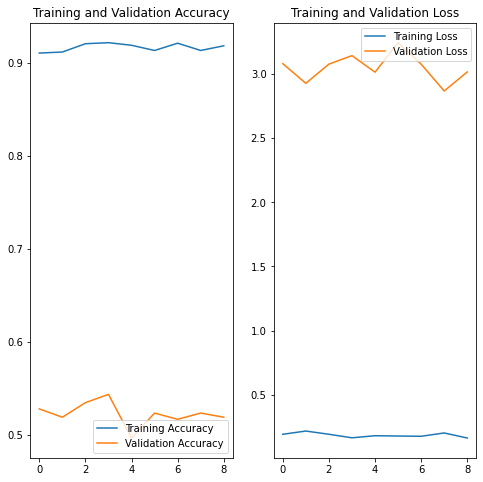

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs_range = range(epochs)
epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Here we can see train data accuracy is incread but not for test still our model is underfit looks like so we will augment our model and retrain with some drop condition

### Distribution of classes in the training dataset

In [45]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,vascular lesion,139
1,squamous cell carcinoma,181
2,seborrheic keratosis,77
3,pigmented benign keratosis,462
4,nevus,357
5,melanoma,438
6,dermatofibroma,95
7,basal cell carcinoma,376
8,actinic keratosis,114


## Visualize the Number of image in each class.

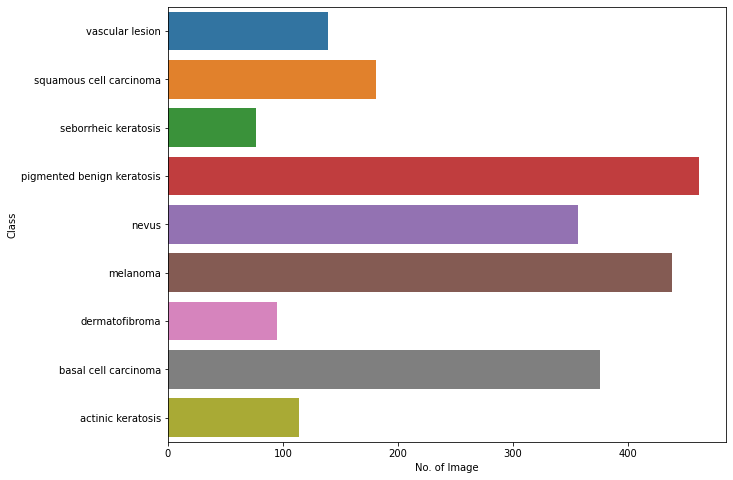

In [46]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [1]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [47]:
path_to_training_dataset = str(data_dir_train)+"/"
print(data_dir_train)
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(path_to_training_dataset) + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

gdrive/My Drive/Colab Notebooks/Train
Initialised with 114 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4DC23CEAD0>: 100%|██████████| 500/500 [00:19<00:00, 26.10 Samples/s]


Initialised with 376 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F4DC5B111D0>: 100%|██████████| 500/500 [00:56<00:00,  8.91 Samples/s] 


Initialised with 95 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4DC5F52610>: 100%|██████████| 500/500 [00:18<00:00, 26.60 Samples/s]


Initialised with 438 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F4DC5AE4550>: 100%|██████████| 500/500 [01:30<00:00,  5.54 Samples/s]


Initialised with 357 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1011x713 at 0x7F4DC5B9C510>: 100%|██████████| 500/500 [01:17<00:00,  6.41 Samples/s]


Initialised with 462 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F4DE6200290>: 100%|██████████| 500/500 [00:18<00:00, 27.26 Samples/s]


Initialised with 77 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F4DCE0A6B90>: 100%|██████████| 500/500 [00:42<00:00, 11.79 Samples/s]


Initialised with 181 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F4DC5AF8DD0>: 100%|██████████| 500/500 [00:18<00:00, 27.48 Samples/s]


Initialised with 139 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4DC2753BD0>: 100%|██████████| 500/500 [00:20<00:00, 24.84 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [67]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [69]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [70]:
# train dataset 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.
  

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [71]:
# val_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   data_dir_train,
#   seed=123,
#   validation_split = 0.2,
#   subset = "validation",
#   image_size=(img_height, img_width),
#   batch_size=batch_size)
# validation dataset 
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [72]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Todo:** Create your model (make sure to include normalization)

In [73]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 41, 41, 128)      

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [74]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

#### **Todo:**  Train your model

In [75]:
# Train the model
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/20
169/169 [==============================] - ETA: 0s - loss: 1.8058 - accuracy: 0.3055
Epoch 1: val_accuracy improved from -inf to 0.38827, saving model to model.h5
169/169 [==============================] - 36s 77ms/step - loss: 1.8058 - accuracy: 0.3055 - val_loss: 1.5697 - val_accuracy: 0.3883
Epoch 2/20
168/169 [============================>.] - ETA: 0s - loss: 1.4706 - accuracy: 0.4491
Epoch 2: val_accuracy improved from 0.38827 to 0.48775, saving model to model.h5
169/169 [==============================] - 7s 42ms/step - loss: 1.4706 - accuracy: 0.4492 - val_loss: 1.3385 - val_accuracy: 0.4878
Epoch 3/20
169/169 [==============================] - ETA: 0s - loss: 1.3515 - accuracy: 0.4931
Epoch 3: val_accuracy improved from 0.48775 to 0.52264, saving model to model.h5
169/169 [==============================] - 7s 40ms/step - loss: 1.3515 - accuracy: 0.4931 - val_loss: 1.2864 - val_accuracy: 0.5226
Epoch 4/20
169/169 [==============================] - ETA: 0s - loss: 1.223

#### **Todo:**  Visualize the model results

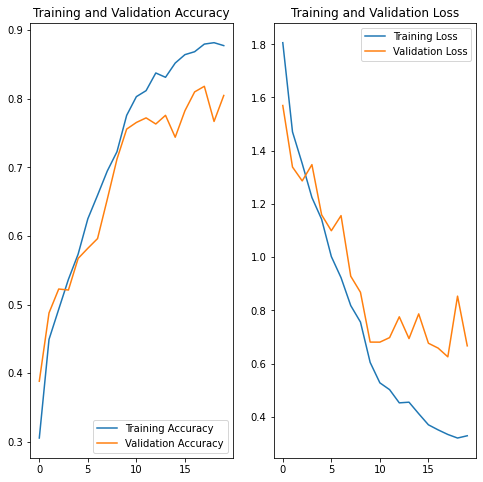

In [76]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Now we can see Train and Test accuracy are getting more than 85%.